In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [111]:
import nltk
nltk.download('stopwords')
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
from numpy import linalg as la
nltk.download('punkt')
import re
import pandas as pd
import json
from wordcloud import WordCloud
from more_itertools import sort_together
from matplotlib import pyplot as plt
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
%cd /content/drive/MyDrive/IRWA Project summary and first deliverable-20231015

/content/drive/MyDrive/IRWA Project summary and first deliverable-20231015


# **1. Pre-processing**

In [6]:
docs_path = 'IRWA_data_2023/Rus_Ukr_war_data.json'
with open(docs_path) as fp:
    lines = fp.readlines()
lines = [l.strip().replace(' +', ' ') for l in lines]

## Define the preporocessing functions we will use

In [73]:
def exteract_url(entities):
    try:
        # delete last 2 slashed from 'https://twitter.com/{user_name}/status/{tweet_id}/video/1' considering it could be different than /video/1
        arr_url = entities['media'][0]['expanded_url'].split('/')
        return "/".join(arr_url[:-2])
    except KeyError:
        return ''

In [80]:
pd.options.mode.chained_assignment = None  # default='warn'
# we convert data to json to structure the lines into a data structure that can be then transformed into a pandas dataframe
datos_diccionario = [json.loads(line) for line in lines]
datos_diccionario_pd = pd.DataFrame(datos_diccionario)
useful_columns_df = datos_diccionario_pd[['id', 'created_at', 'full_text', 'favorite_count', 'retweet_count']]
useful_columns_df['hashtags'] = datos_diccionario_pd['entities'].apply(lambda x: [d['text'] for d in x['hashtags']])
useful_columns_df['url'] = datos_diccionario_pd['entities'].apply(exteract_url)

In [78]:
def preprocess(full_text):
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    full_text=  full_text.lower()
    # rename all urls 
    full_text = re.sub(url_pattern, '', full_text)
    # remove all words that start with #
    full_text = re.sub(r'#\w+', '', full_text)
    return full_text

In [83]:
#preprocess
def build_terms(line, tokenize=True):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    line = preprocess(line)

    line=  nltk.tokenize.word_tokenize(line) ## Tokenize the text to get a list of terms
    line=[word for word in line if re.match(r'^\w+$', word)] ## remove punctuation
    line=[word for word in line if word not in stop_words]  ##eliminate the stopwords
    line=[nltk.stem.SnowballStemmer('english').stem(word) for word in line] ## perform stemming )

    if tokenize:
        return line
    else:
        return ' '.join(line)

## Create mapping between tweets and document id's

In [85]:
tweedid_2_docid = {}
docid_2_tweedid = {}
doc_info = {}
for indexes, row in useful_columns_df.iterrows():
    # create mapping between tweet_id and doc_id, and viceversa
    tweedid_2_docid[row['id']] = f"doc_{indexes+1}"
    docid_2_tweedid[f"doc_{indexes+1}"] = row['id']
    # create dictionary with doc_id and document information structures as such: Tweet | Date | Hashtags | Likes | Retweets | Url
    doc_info[f"doc_{indexes+1}"] = " | ".join([build_terms(row['full_text'], tokenize=False), row['created_at'], ", ".join(row['hashtags']), 
                                               str(row['favorite_count']), str(row['retweet_count']), row['url']])

# **2. Exploratory Data Analysis**

In [94]:
# we preprocess all the data to obtain terms[i] which is data preprocessed, 
terms_wo_hastags = [build_terms(row['full_text']) for _, row in useful_columns_df.iterrows()]
terms_with_hastags= [build_terms(row['full_text']) + [preprocess(hashtag) for hashtag in row['hashtags']] for _, row in useful_columns_df.iterrows()]

## Word count boxplot

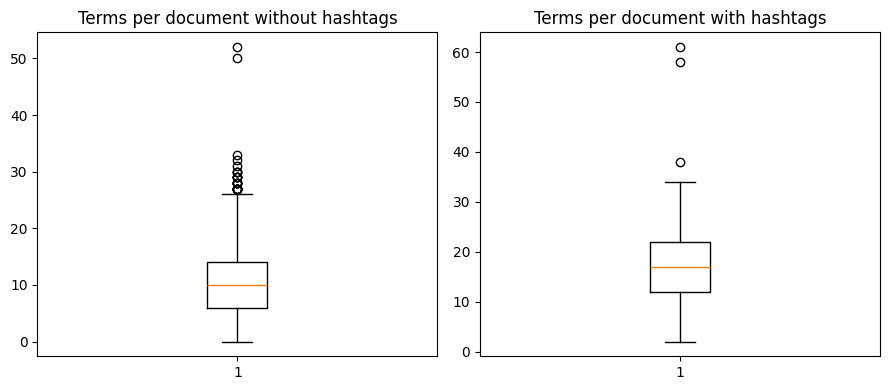

In [103]:
# display a boxplot of the number of terms per document (with and without hashtags) into one same figure with 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
axes[0].boxplot([len(doc) for doc in terms_wo_hastags])
axes[0].set_title('Terms per document without hashtags')
axes[1].boxplot([len(doc) for doc in terms_with_hastags])
axes[1].set_title('Terms per document with hashtags')
fig.tight_layout()
plt.show()

## Historic number of tweets per day

In [129]:
def convert_date(str_date):
    date_array = str_date.split(' ')
    date_array[-2] = '+'+date_array[-2]
    str_date_mod = " ".join(date_array)
    return datetime.strptime(str_date_mod, '%a %b %d %H:%M:%S %z %Y').date()

In [133]:
useful_columns_df['created_at'] = useful_columns_df['created_at'].apply(convert_date)


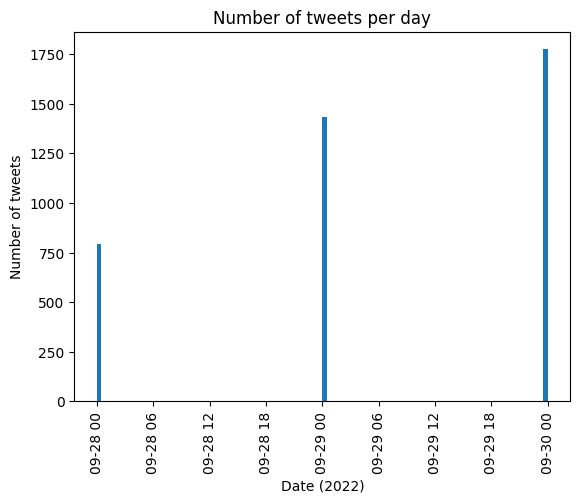

In [138]:
# create a histogram with the number of tweets per day and have the dates in the x-axis be vertically oriented
plt.hist(useful_columns_df['created_at'], bins=100)
plt.xlabel('Date (2022)')
plt.xticks(rotation=90)
plt.ylabel('Number of tweets')
plt.title('Number of tweets per day')
plt.show()


## Get the 10 most retweeted and saves as favourite tweets

In [167]:
# print the 10 most retweeted tweets (with their doc_id) and the respective number of retweets
most_retweeted_tweets = useful_columns_df.sort_values(by='retweet_count', ascending=False)
for indexes, row in most_retweeted_tweets.head(10).iterrows():
    print(f"{tweedid_2_docid[row['id']]} | {row['retweet_count']}")
    print(row['full_text'])
    print("\n")

doc_1220 | 646
🗺️Situation around Lyman - Sep 30 11:00:
- UA forces liberated Yampil and advancing north
- RU troops are reportedly abandoning its positions in Drobysheve
- The only exit route from Lyman is within the firing range of UA forces
#UkraineRussiaWar https://t.co/jGJUhXcr1y


doc_2814 | 338
📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.
#UkraineRussiaWar https://t.co/AmSijyM59c


doc_3766 | 283
📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canadian instructors in the UK.
#UkraineRussiaWar https://t.co/oYWThs8qNe


doc_1847 | 251
The following countries have urged their citizens to leave 🇷🇺 will update if other governments make similar statements. 
#UkraineRussiaWar #AnnexationofUkraine
#NAFO 

Poland 🇵🇱
Estonia 🇪🇪
Latvia 🇱🇻
Italy 🇮🇹
United States 🇺🇲
Bulgaria 🇧🇬
Romania 🇷🇴
Tai

In [169]:
# print the 10 most favourite tweets (with their doc_id) and the respective number of favourites
most_favorite_tweets = useful_columns_df.sort_values(by='favorite_count', ascending=False)
for indexes, row in most_favorite_tweets.head(10).iterrows():
    print(f"{tweedid_2_docid[row['id']]} | {row['favorite_count']}")
    print(row['full_text'])
    print("\n")

doc_1220 | 3701
🗺️Situation around Lyman - Sep 30 11:00:
- UA forces liberated Yampil and advancing north
- RU troops are reportedly abandoning its positions in Drobysheve
- The only exit route from Lyman is within the firing range of UA forces
#UkraineRussiaWar https://t.co/jGJUhXcr1y


doc_2814 | 2685
📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.
#UkraineRussiaWar https://t.co/AmSijyM59c


doc_3766 | 2155
📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canadian instructors in the UK.
#UkraineRussiaWar https://t.co/oYWThs8qNe


doc_2824 | 1631
📷🇨🇿 Czech volunteer during the ongoing offensive of Ukrainian Forces in #Kharkiv Oblast. #UkraineRussiaWar https://t.co/u9tnLGvXlw


doc_206 | 1407
📽️🇺🇦 Ukrainian forces liberated Drobysheve in #Donetsk Oblast. 
#UkraineRussiaWar https://t.co/7wUC

In [179]:

display(most_retweeted_tweets[['retweet_count']].head(10), most_favorite_tweets[['favorite_count']].head(10))

,retweet_count
1219,646
2813,338
3765,283
1846,251
1387,247
1209,236
1532,184
205,171
2118,136
3801,133


,favorite_count
1219,3701
2813,2685
3765,2155
2823,1631
205,1407
2118,1407
3801,1348
450,1083
1846,923
1244,868


## Worldcloud of most frequent words for tweets considering hashtags and not

In [150]:
def matrix_to_line(matrix):
    return " ".join([item for sublist in matrix for item in sublist])

Text(0.5, 1.0, 'Word Cloud for....')

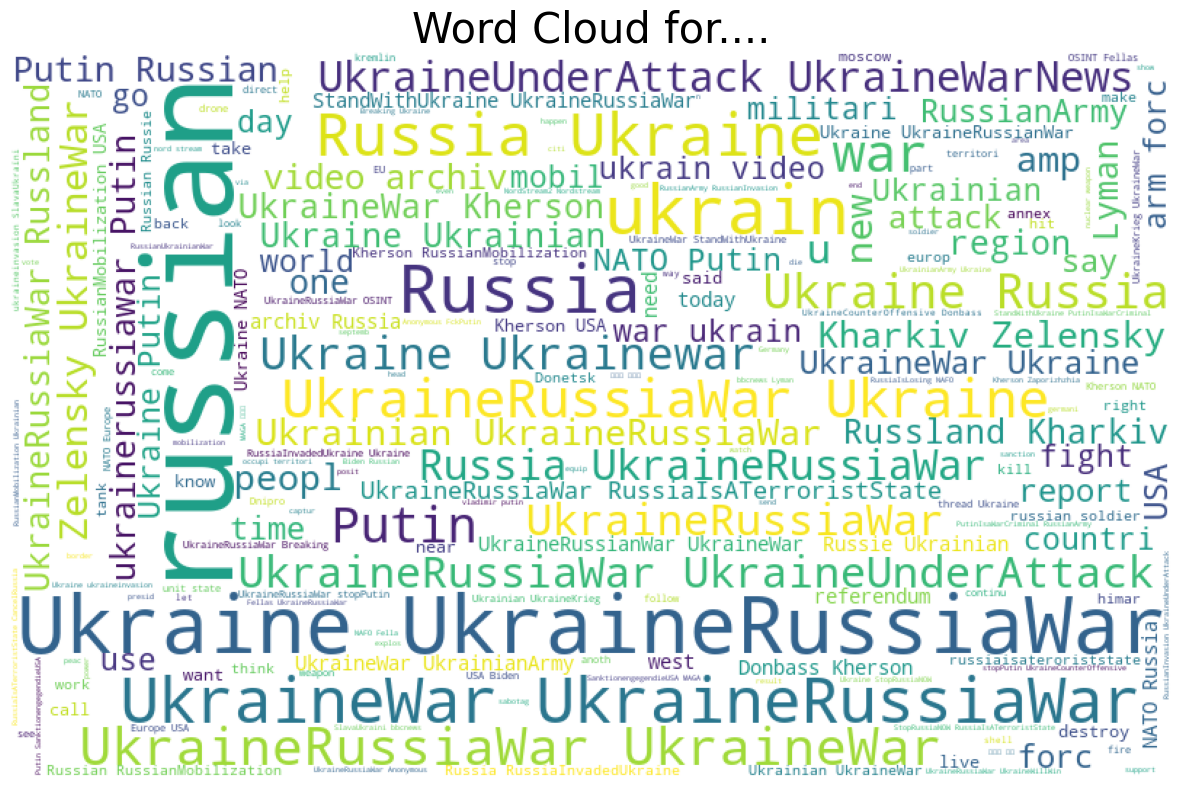

In [152]:
# Generate a wordcloud for our dataset
# Generating wordcloud using the text concatenated
plt.figure(figsize=(15, 15))
wc = WordCloud(background_color='white',
               width=800,
               height=500).generate(matrix_to_line(terms_with_hastags))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud for....', fontsize=30)

Text(0.5, 1.0, 'Word Cloud for....')

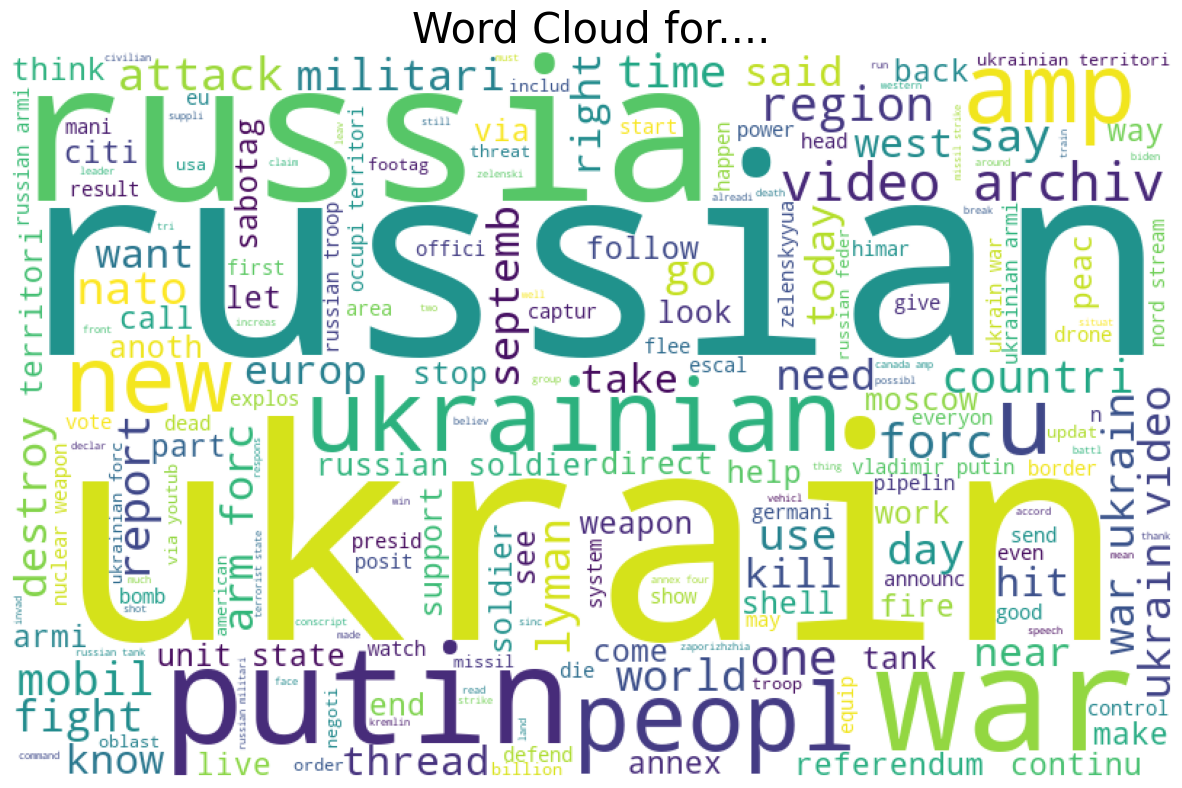

In [153]:
# Generate a wordcloud for our dataset
# Generating wordcloud using the text concatenated
plt.figure(figsize=(15, 15))
wc = WordCloud(background_color='white',
               width=800,
               height=500).generate(matrix_to_line(terms_wo_hastags))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud for....', fontsize=30)